In [1]:
import click
import pickle
import torch
from calibration.ece import ECELoss
import dnnlib
import os
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

/home/lorenzo/miniconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import json
from typing import Dict, List

def flatten_metrics(json_obj: Dict) -> Dict:
    """Flatten nested metrics structure into a single level dictionary."""
    flattened = {}
    
    for key, value in json_obj.items():
        # Skip the num/std fields and only keep the mean values
        if isinstance(value, dict) and 'mean' in value:
            flattened[key] = value['mean']
        else:
            flattened[key] = value
            
    return flattened

def parse_metrics_file(file_path: str) -> pd.DataFrame:
    """Parse metrics file where each line is a JSON object into a DataFrame."""
    # Read the file line by line and parse each JSON object
    records = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                json_obj = json.loads(line.strip())
                flattened = flatten_metrics(json_obj)
                records.append(flattened)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")
                continue
    
    # Convert to DataFrame
    df = pd.DataFrame(records)
    
    # Convert timestamp to datetime
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    return df

In [3]:
df = parse_metrics_file('training-runs/00022-train-cond-ebm-pedm-gpus2-batch128-fp32/stats.jsonl')

FileNotFoundError: [Errno 2] No such file or directory: 'training-runs/00022-train-cond-ebm-pedm-gpus2-batch128-fp32/stats.jsonl'

In [ ]:
df

,train/cls_acc,train/cls_loss,train/cls_ece,train/sm_loss,val/cls_loss,val/cls_acc,val/cls_ece,Progress/tick,Progress/kimg,Timing/total_sec,Timing/sec_per_tick,timestamp
0,0.011719,0.796219,0.001719,0.990398,4.605170,0.010848,0.010784,0.0,0.320000,31.405958,26.380442,2024-11-12 13:21:47.721296787
1,0.021198,0.839428,0.013768,1.037874,4.605170,0.010848,0.010784,1.0,50.560001,511.592957,479.418610,2024-11-12 13:29:47.141264439
2,0.016558,0.982610,0.009933,0.979425,4.605170,0.010848,0.010784,2.0,100.800003,992.651367,481.057129,2024-11-12 13:37:48.199663877
3,0.014493,0.942366,0.008883,0.803716,4.605170,0.010848,0.010784,3.0,151.039993,1473.740356,481.087677,2024-11-12 13:45:49.288636446
4,0.017267,0.898628,0.010445,0.649239,4.605170,0.010848,0.010784,4.0,201.279999,1957.029175,483.287567,2024-11-12 13:53:52.577500105
...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.999963,0.000041,0.002196,0.216508,0.002013,1.000000,0.001892,78.0,3919.040039,37577.066406,477.575806,2024-11-12 23:47:32.614471912
79,0.999950,0.000058,0.002148,0.220899,0.002013,1.000000,0.001892,79.0,3969.280029,38056.492188,479.423950,2024-11-12 23:55:32.039835691
80,0.999988,0.000034,0.002007,0.216677,0.001823,1.000000,0.001722,80.0,4019.520020,38550.824219,494.331451,2024-11-13 00:03:46.372857809
81,0.999938,0.000034,0.001614,0.217514,0.001823,1.000000,0.001722,81.0,4069.760010,39028.933594,478.108002,2024-11-13 00:11:44.482203960


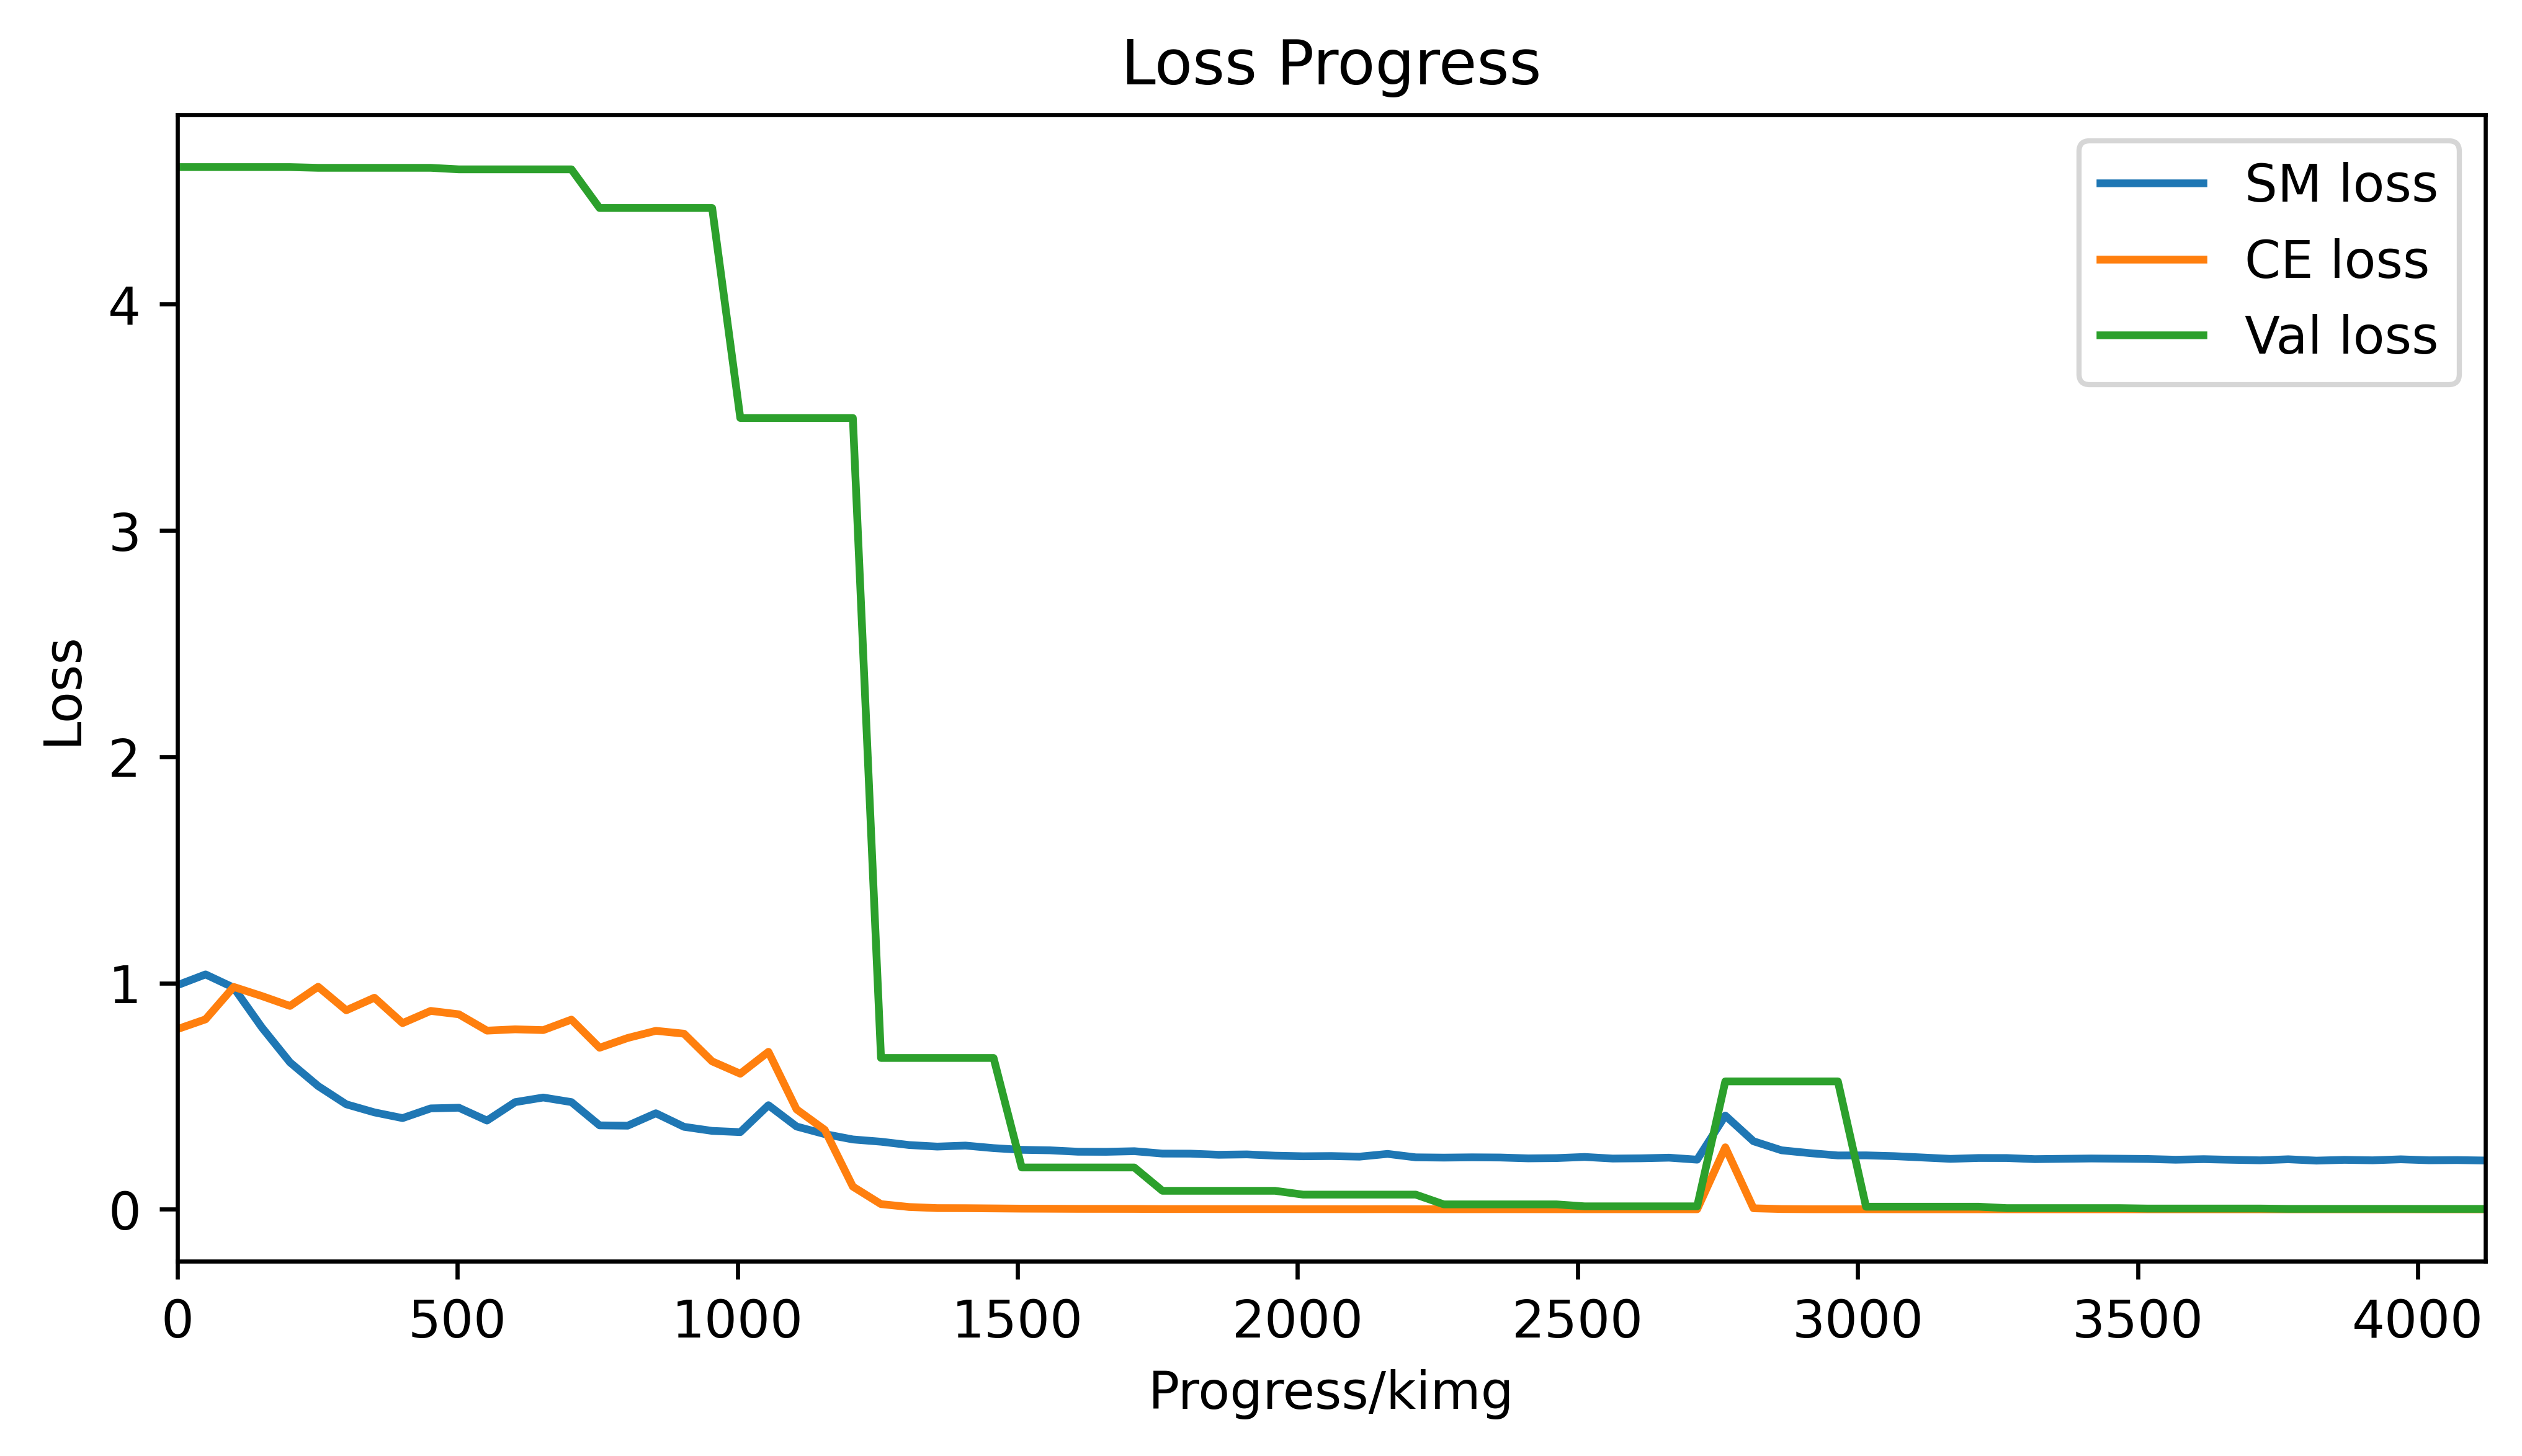

In [ ]:
# create plot of progress/kimg
plt.figure(figsize=(8, 4), dpi=600)

plt.xlim(0, df['Progress/kimg'].max())
plt.title('Loss Progress')
plt.xlabel('Progress/kimg')
plt.ylabel('Loss')
plt.plot(df['Progress/kimg'], df['train/sm_loss'], label='SM loss')
plt.plot(df['Progress/kimg'], df['train/cls_loss'], label='CE loss')
plt.plot(df['Progress/kimg'], df['val/cls_loss'], label='Val loss')
plt.legend()
plt.show()

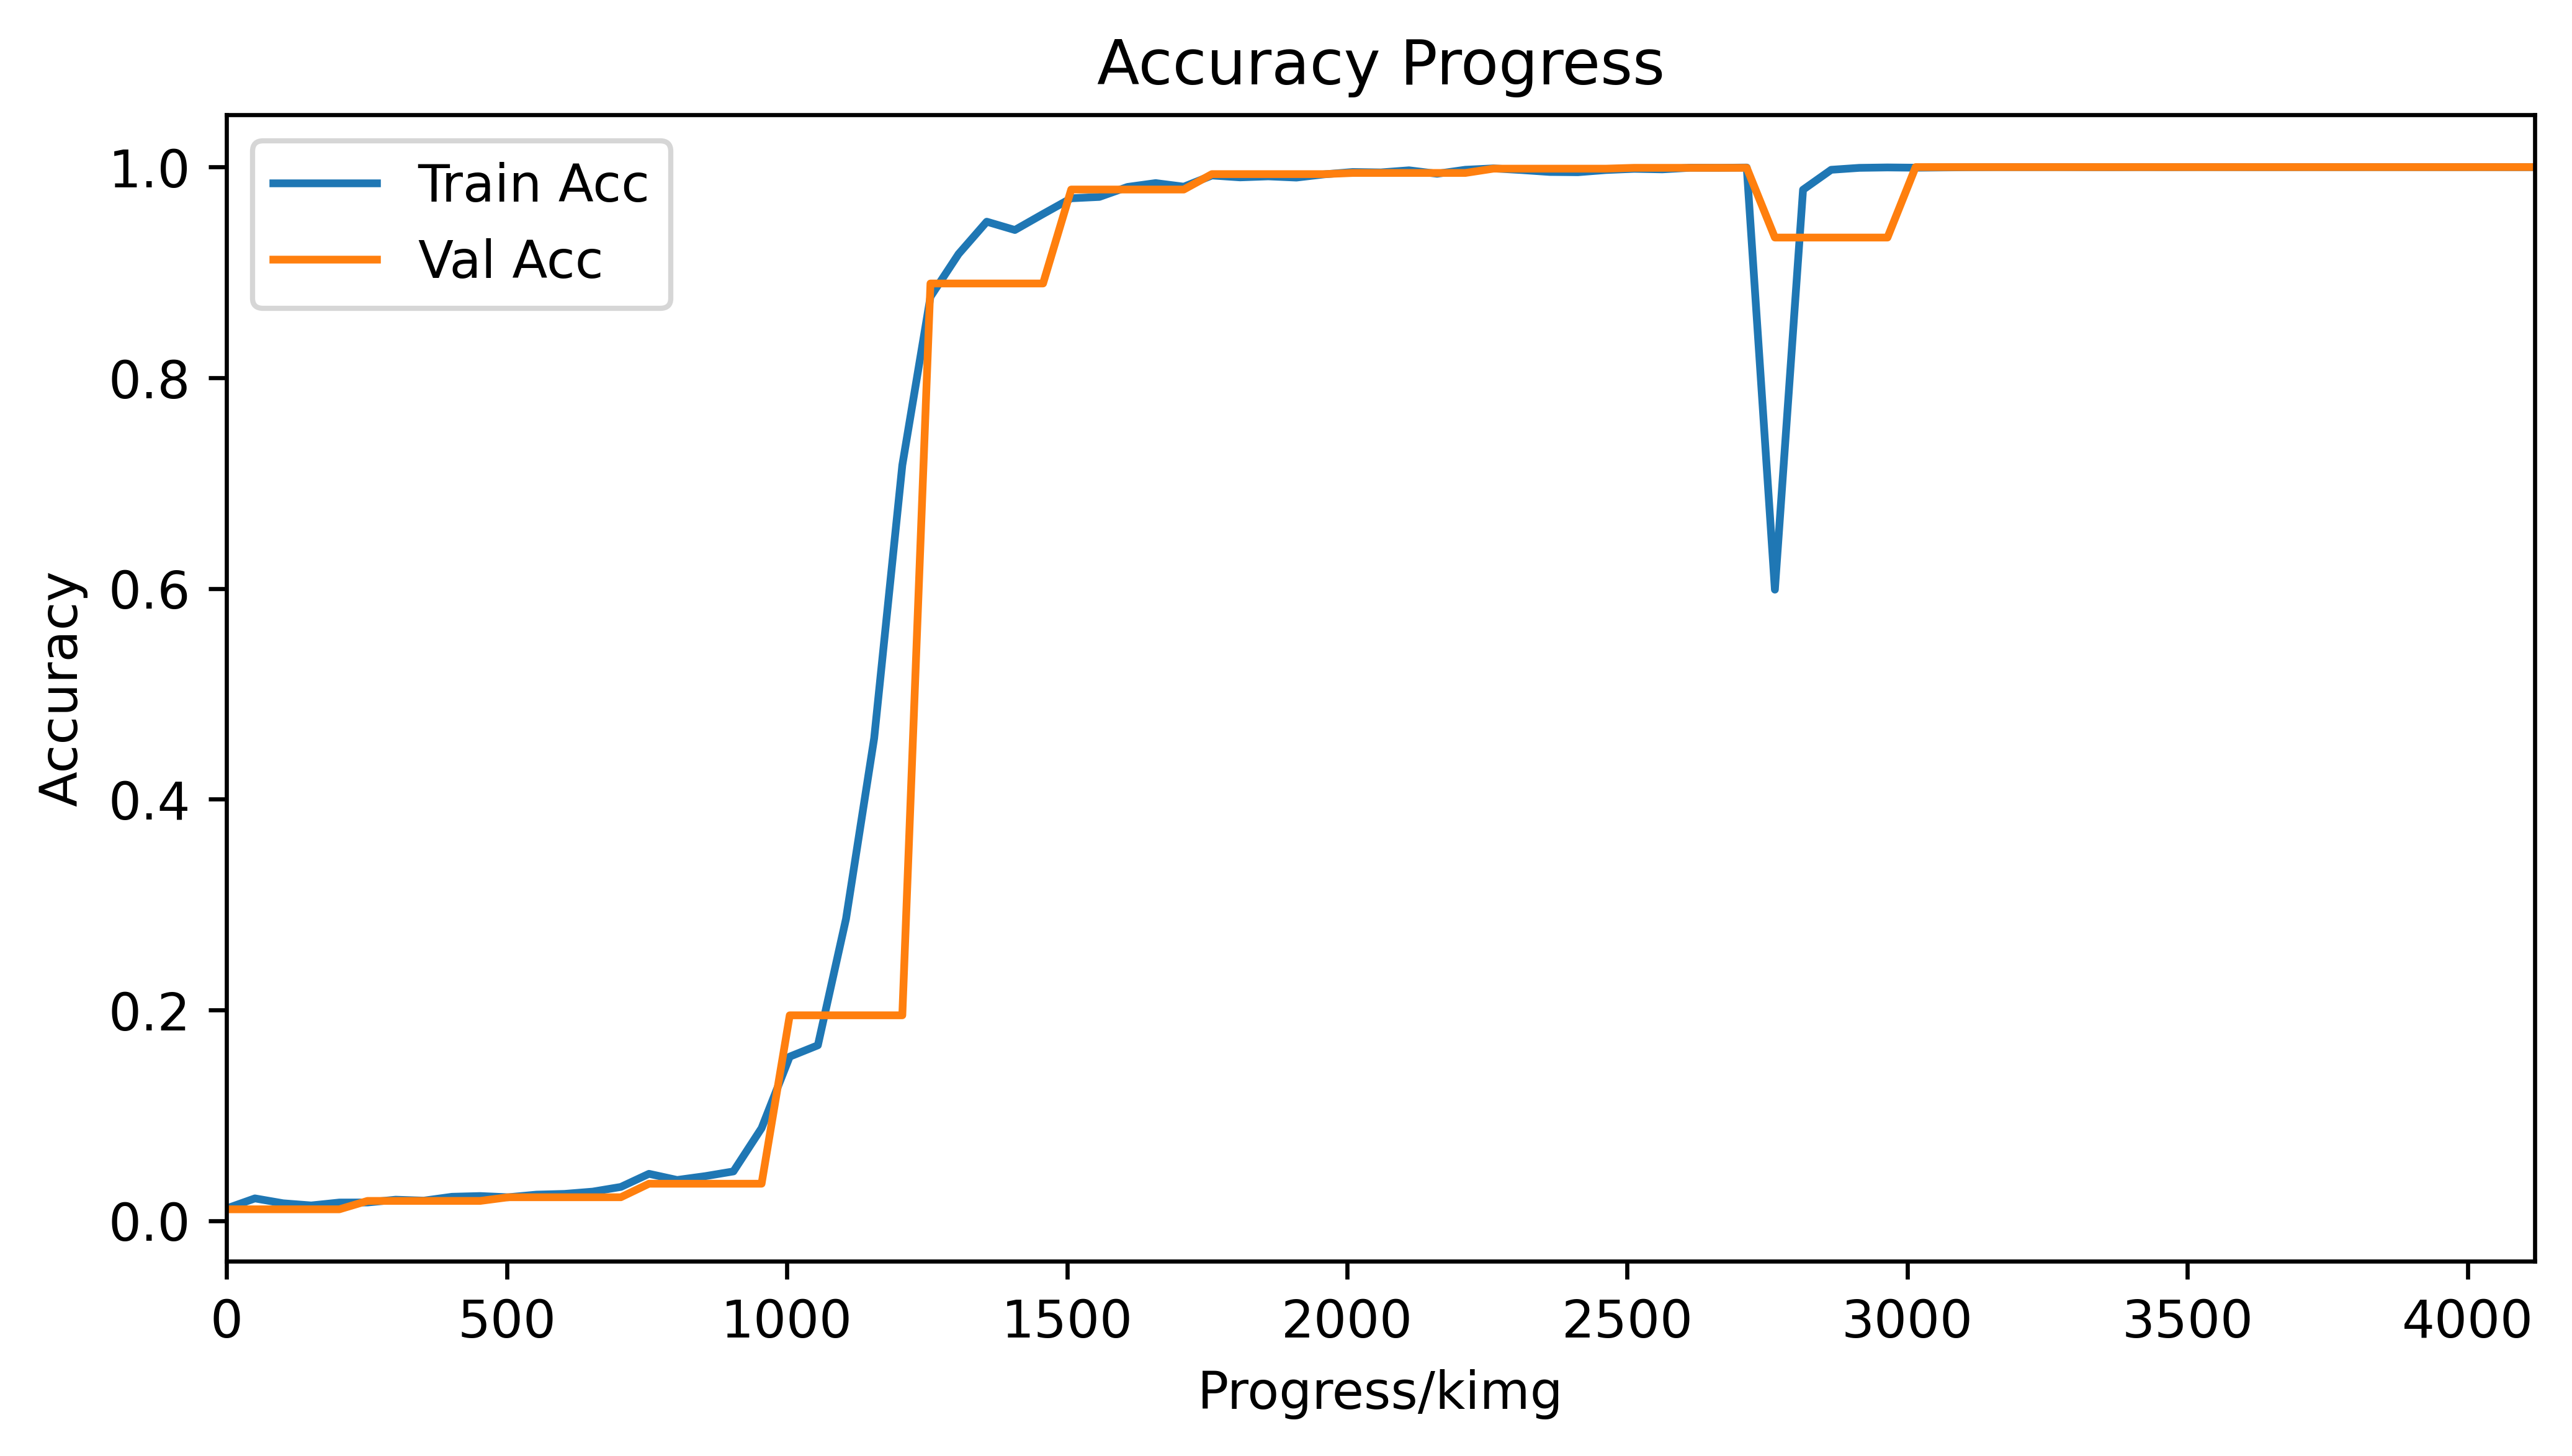

In [ ]:
plt.figure(figsize=(8, 4), dpi=600)

plt.xlim(0, df['Progress/kimg'].max())
plt.title('Accuracy Progress')
plt.xlabel('Progress/kimg')
plt.ylabel('Accuracy')
plt.plot(df['Progress/kimg'], df['train/cls_acc'], label='Train Acc')
plt.plot(df['Progress/kimg'], df['val/cls_acc'], label='Val Acc')
plt.legend()

plt.show()

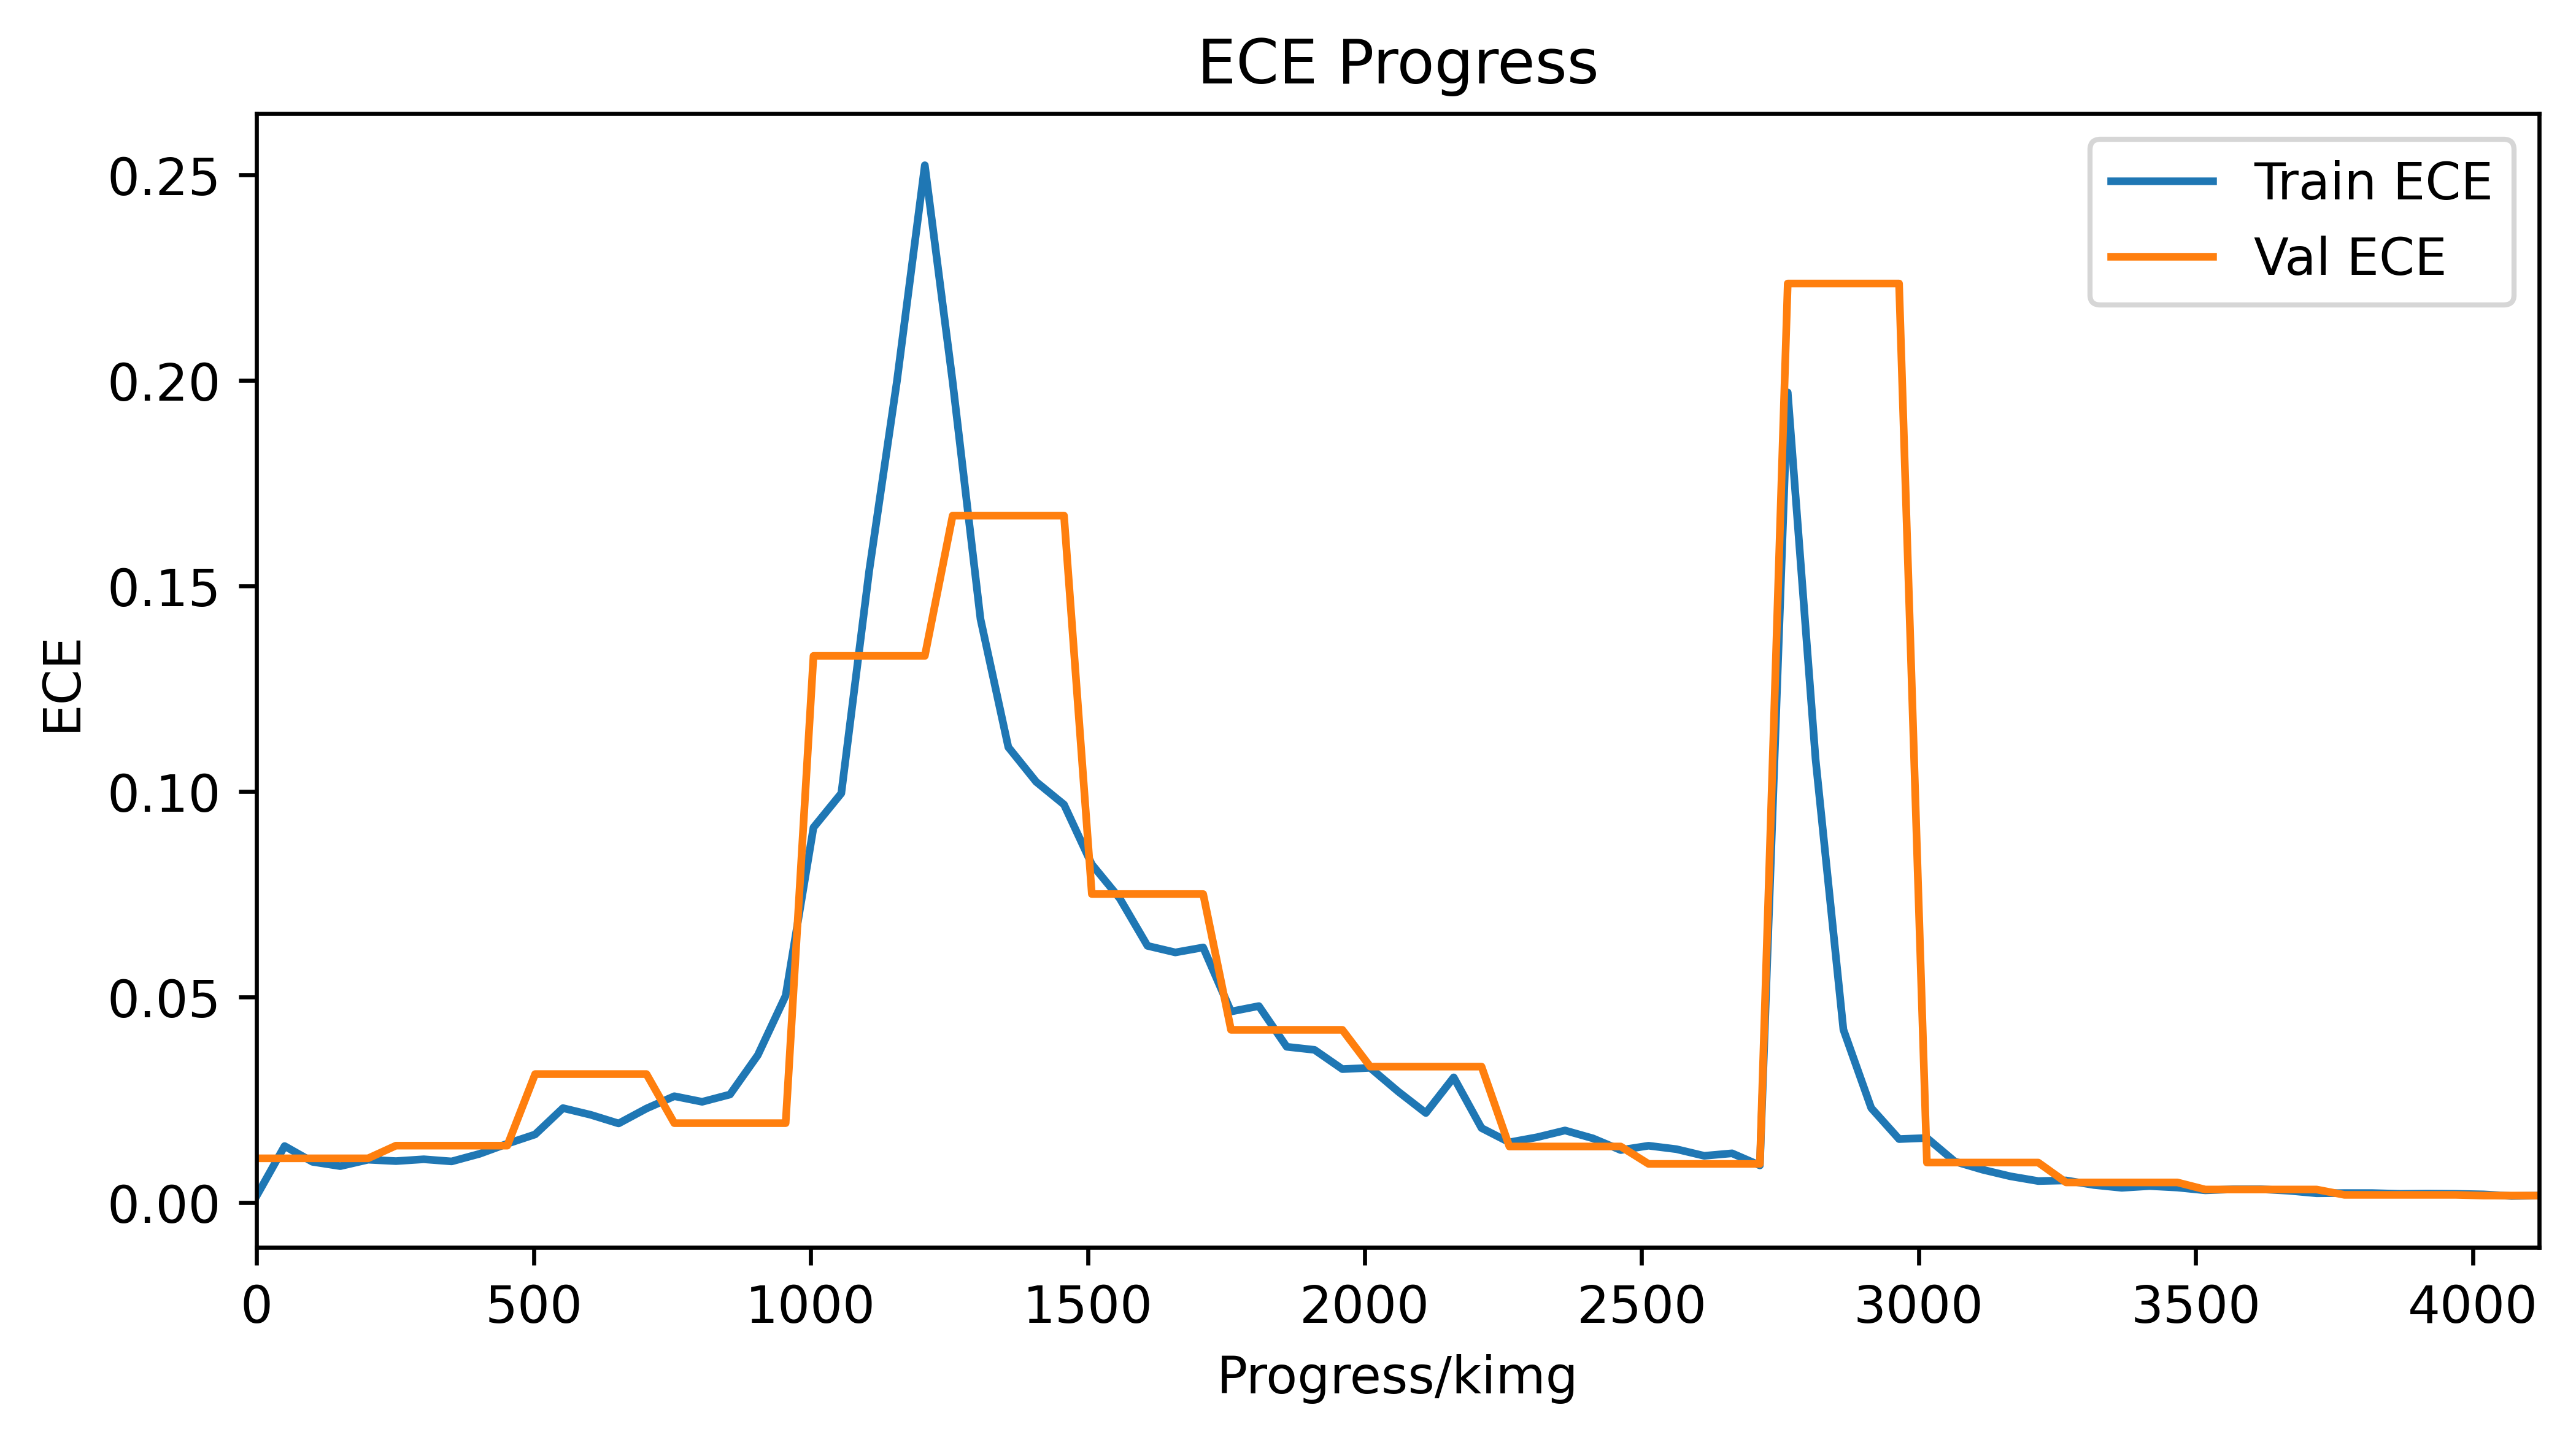

In [ ]:
plt.figure(figsize=(8, 4), dpi=600)

plt.xlim(0, df['Progress/kimg'].max())
plt.title('ECE Progress')
plt.xlabel('Progress/kimg')
plt.ylabel('ECE')
plt.plot(df['Progress/kimg'], df['train/cls_ece'], label='Train ECE')
plt.plot(df['Progress/kimg'], df['val/cls_ece'], label='Val ECE')
plt.legend()

plt.show()

In [4]:
def eval_cls(net, loss_fn, dataloader, resolution, device):
    losses, accs, eces = [], [], []
    
    # Store all predictions
    all_images = []
    all_preds = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device).to(torch.float32) / 127.5 - 1
            labels = labels.to(device)

            logits, ce_loss = loss_fn(
                net=net,
                images=images,
                labels=labels,
                patch_size=resolution,
                cls_mode=True,
                eval_mode=True
            )

            # Get predicted and true classes
            predicted = logits.argmax(dim=1)
            true_labels = labels.argmax(dim=1)
            confidences = torch.softmax(logits, dim=1).max(dim=1)[0]

            # Store predictions
            all_images.extend(images.cpu())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

            # Update metrics
            acc = (predicted == true_labels).float().mean()  
            ece = ECELoss()(logits, true_labels)  

            losses.append(ce_loss.mean().item())
            accs.append(acc.item())
            eces.append(ece.item())

    predictions = {
        'images': torch.stack(all_images),
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'confidences': np.array(all_confidences)
    }

    return np.mean(losses), np.mean(accs), np.mean(eces), predictions

In [5]:
# To run this script, use the following command:
# python test_cls.py --network <network_pkl> --outdir <outdir> --test_dir <test_dir>
# Example:
# python test_cls.py --network training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-000000.pkl --outdir results --test_dir ../data/cifar10/test.zip
# python test_cls.py --network training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-015072.pkl --outdir results --test_dir ../data/cifar10/test.zip
# 002512
# 005024
# 007536
network_pkl = "training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-005024.pkl"
test_dir = "./data/cifar100/test"
device = torch.device("cuda")

# Load the model.
with open(network_pkl, "rb") as f:
    net = pickle.load(f)["ema"].to(device)
net.eval()

loss_kwargs = {"class_name": "training.patch_loss.PatchEDMLoss"}
loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)  # training.loss.(VP|VE|EDM)Loss

c = dnnlib.EasyDict()

# Load the test data.
c.test_dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=test_dir,
    use_labels=True,
    xflip=False,
    cache=True,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    batch_size=128,
    pin_memory=True,
    num_workers=1,
    prefetch_factor=2,
)
test_dataset_obj = dnnlib.util.construct_class_by_name(**c.test_dataset_kwargs)
test_dataloader = torch.utils.data.DataLoader(test_dataset_obj, **c.data_loader_kwargs)

In [6]:
# First run evaluation
test_loss, test_acc, test_ece, predictions = eval_cls(
    net, loss_fn, test_dataloader, test_dataset_obj.resolution, device
)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


TypeError: forward() got an unexpected keyword argument 'eval_mode'

In [ ]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test ECE: {test_ece}")

Test Loss: 4.605170913889438
Test Accuracy: 0.009889240506329115
Test ECE: 0.006673303503495983


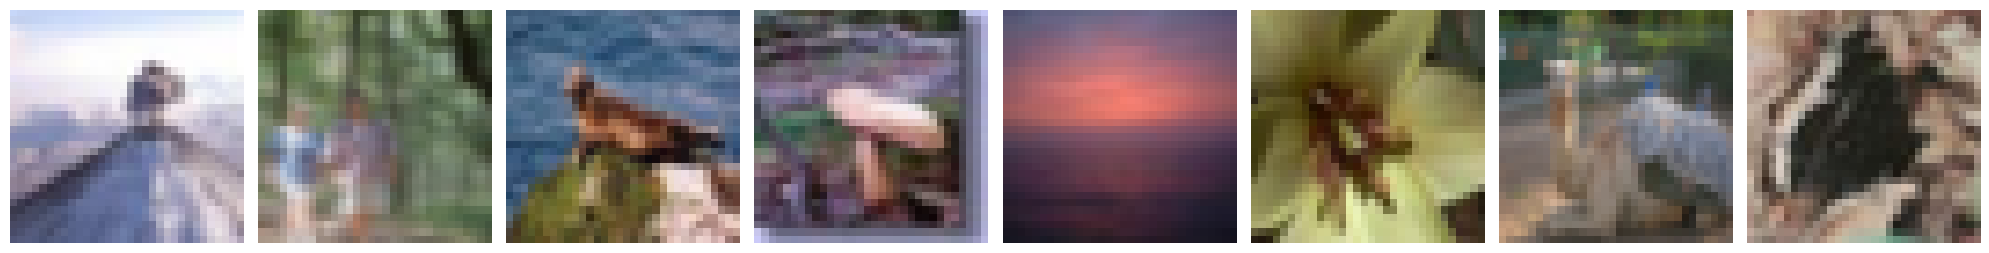

In [ ]:
# Get lowest confidence images
lowest_confidence_indices = np.argsort(predictions['confidences'])
lowest_confidence_images = predictions['images'][lowest_confidence_indices]

# Get highest confidence images
highest_confidence_indices = np.argsort(-predictions['confidences'])
highest_confidence_images = predictions['images'][highest_confidence_indices]

# Get correct and incorrect predictions
correct_indices = np.where(predictions['predictions'] == predictions['labels'])[0]
incorrect_indices = np.where(predictions['predictions'] != predictions['labels'])[0]

# Get correct and incorrect predictions with highest confidence
correct_highest_confidence_indices = np.intersect1d(correct_indices, highest_confidence_indices)
incorrect_highest_confidence_indices = np.intersect1d(incorrect_indices, highest_confidence_indices)

# Get correct and incorrect predictions with lowest confidence
correct_lowest_confidence_indices = np.intersect1d(correct_indices, lowest_confidence_indices)
incorrect_lowest_confidence_indices = np.intersect1d(incorrect_indices, lowest_confidence_indices)

# plot images
def plot_images(images, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))
    
    for i, img in enumerate(images[:num_images]):
        axs[i].imshow((img.permute(1, 2, 0) + 1) / 2)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# plot_images(lowest_confidence_images, num_images=8)
# plot_images(highest_confidence_images, num_images=8)
# plot_images(predictions['images'][correct_indices], num_images=8)
# plot_images(predictions['images'][incorrect_indices], num_images=8)
plot_images(predictions['images'][incorrect_highest_confidence_indices], num_images=8)
# plot_images(predictions['images'][correct_lowest_confidence_indices], num_images=8)


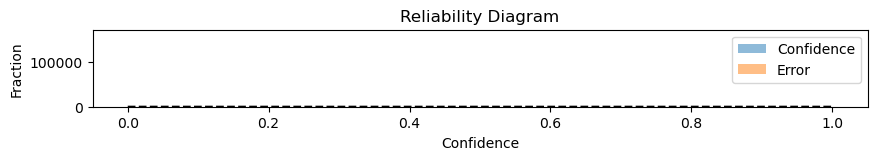

In [ ]:
n_bins = 10
one_hot_confidences = np.eye(100)[predictions['labels']] * predictions['confidences'][:, None]

# plot reliability diagram
plt.figure(figsize=(10, 1))
plt.plot([0, 1], [0, 1], 'k--')
plt.hist(predictions['confidences'], bins=n_bins, weights=np.ones_like(predictions['confidences']) / len(predictions['confidences']), alpha=0.5, label='Confidence')
plt.hist(predictions['confidences'], bins=n_bins, weights=np.abs(predictions['labels'] - predictions['confidences']), alpha=0.5, label='Error')
plt.xlabel('Confidence')
plt.ylabel('Fraction')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

In [ ]:
def plot_predictions(predictions, num_samples=15, start_idx=0):
    """
    Plot prediction results with original images, predicted labels, true labels, and confidence scores.
    
    Args:
        predictions (dict): Dictionary containing 'images', 'predictions', 'labels', 'confidences'
        num_samples (int): Number of samples to plot
        start_idx (int): Starting index for plotting samples
    """
    images = predictions['images']
    predicted_labels = predictions['predictions']
    true_labels = predictions['labels']
    confidences = predictions['confidences']
    
    # Select subset of samples
    end_idx = min(start_idx + num_samples, len(images))
    images = images[start_idx:end_idx]
    predicted_labels = predicted_labels[start_idx:end_idx]
    true_labels = true_labels[start_idx:end_idx]
    confidences = confidences[start_idx:end_idx]
    
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    # # CIFAR-10 class names
    # class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
    #               'dog', 'frog', 'horse', 'ship', 'truck']

    class_names  = [
    'apple',        # 0
    'aquarium_fish',# 1
    'baby',         # 2
    'bear',         # 3
    'beaver',       # 4
    'bed',          # 5
    'bee',          # 6
    'beetle',       # 7
    'bicycle',      # 8
    'bottle',       # 9
    'bowl',         # 10
    'boy',          # 11
    'bridge',       # 12
    'bus',          # 13
    'butterfly',    # 14
    'camel',        # 15
    'can',          # 16
    'castle',       # 17
    'caterpillar',  # 18
    'cattle',       # 19
    'chair',        # 20
    'chimpanzee',   # 21
    'clock',        # 22
    'cloud',        # 23
    'cockroach',    # 24
    'couch',        # 25
    'crab',         # 26
    'crocodile',    # 27
    'cup',          # 28
    'dinosaur',     # 29
    'dolphin',      # 30
    'elephant',     # 31
    'flatfish',     # 32
    'forest',       # 33
    'fox',          # 34
    'girl',         # 35
    'hamster',      # 36
    'house',        # 37
    'kangaroo',     # 38
    'keyboard',     # 39
    'lamp',         # 40
    'lawn_mower',   # 41
    'leopard',      # 42
    'lion',         # 43
    'lizard',       # 44
    'lobster',      # 45
    'man',          # 46
    'maple_tree',   # 47
    'motorcycle',   # 48
    'mountain',     # 49
    'mouse',        # 50
    'mushroom',     # 51
    'oak_tree',     # 52
    'orange',       # 53
    'orchid',       # 54
    'otter',        # 55
    'palm_tree',    # 56
    'pear',         # 57
    'pickup_truck', # 58
    'pine_tree',    # 59
    'plain',        # 60
    'plate',        # 61
    'poppy',        # 62
    'porcupine',    # 63
    'possum',       # 64
    'rabbit',       # 65
    'raccoon',      # 66
    'ray',          # 67
    'road',         # 68
    'rocket',       # 69
    'rose',         # 70
    'sea',          # 71
    'seal',         # 72
    'shark',        # 73
    'shrew',        # 74
    'skunk',        # 75
    'skyscraper',   # 76
    'snail',        # 77
    'snake',        # 78
    'spider',       # 79
    'squirrel',     # 80
    'streetcar',    # 81
    'sunflower',    # 82
    'sweet_pepper', # 83
    'table',        # 84
    'tank',         # 85
    'telephone',    # 86
    'television',   # 87
    'tiger',        # 88
    'tractor',      # 89
    'train',        # 90
    'trout',        # 91
    'tulip',        # 92
    'turtle',       # 93
    'wardrobe',     # 94
    'whale',        # 95
    'willow_tree',  # 96
    'wolf',         # 97
    'woman',        # 98
    'worm'          # 99
] 
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        
        pred_name = class_names[predicted_labels[i]]
        true_name = class_names[true_labels[i]]
        
        # Add color to title based on correctness
        color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
        
        ax.imshow(img)
        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confidences[i]:.2f}", 
                    color=color)
        ax.axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

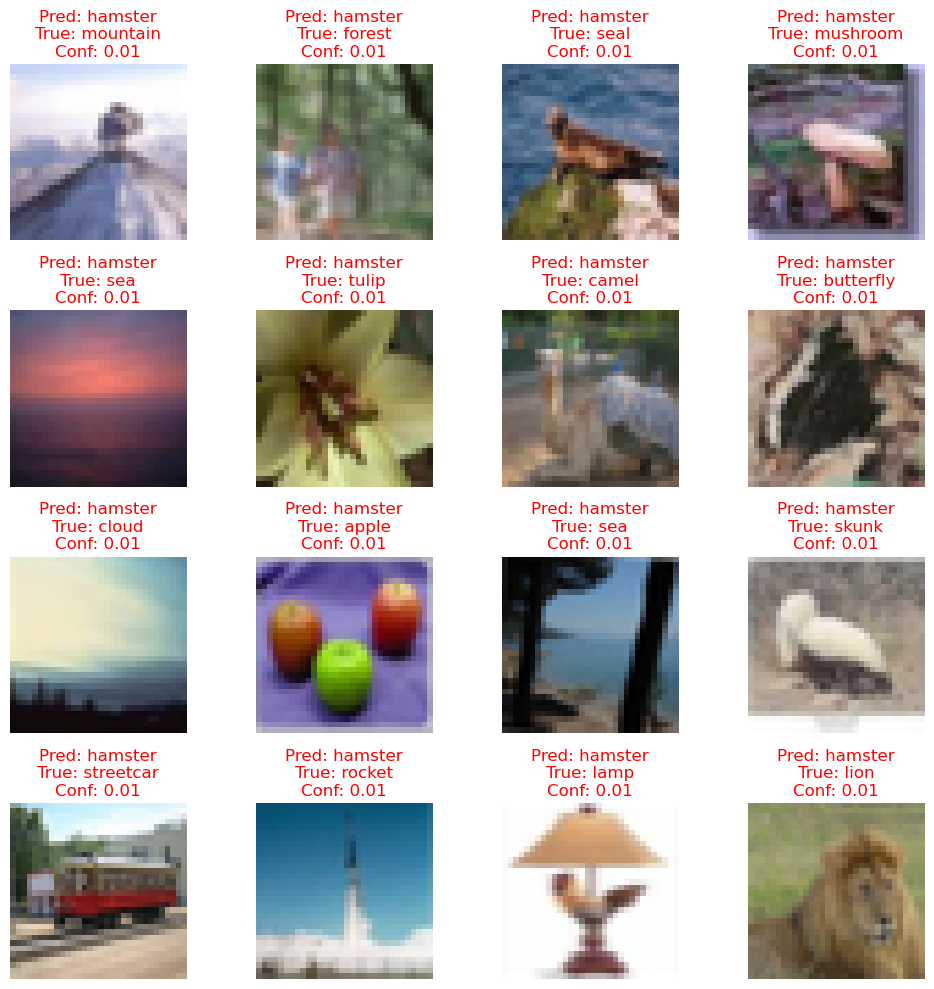

In [ ]:
# Then plot predictions
plot_predictions(predictions, num_samples=16)  # Plot first 15 samples